# Import required libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import polars as pl
#import duckdb as dd
#from tqdm import tqdm
import matplotlib.pyplot as plt
#import cv2
#from pydicom import dcmread
import warnings
#from sklearn.preprocessing import LabelEncoder
import pickle
#import gc
import ctypes
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()

"""for gpu in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)"""
    
import tensorflow_io as tfio
from tensorflow import keras

#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [28]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


In [29]:
# strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

BATCH_SIZE_PER_REPLICA = 48

#We obtain the BATCH_SIZE dividing by the number of devices. 
#BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * 2

DEVICES AVAILABLE: 1


# Feature extraction from image files
## Only if not using tensorflow
### kept here as backward compatibility with earlier work

In [ ]:
metadata_root_path = '/kaggle/input/spinal-canal-stenosis-metadata'

for file in os.listdir(metadata_root_path):
    labels = []
    features = []
    data = {}
    metadata_file_path = os.path.join(metadata_root_path, file)
    print(metadata_file_path)
    metadata_df = pl.read_csv(metadata_file_path, low_memory=True)
    for j in tqdm(range(metadata_df.shape[0])):
        dcm_image_path = metadata_df.item(j,0)
        dicom_ds = dcmread(dcm_image_path)
        img_array = dicom_ds.pixel_array
        features.append(np.mean(img_array.T, axis=0))
        # features.append(dcmread(dcm_image_path).pixel_array)
        labels.append(metadata_df.item(j,2))

    print("feature list length --> ", len(features))
    print("label list length --> ", len(labels))

    #extracted_training_features = np.array([np.resize(img,(128,128)) for img in features])
    #training_labels = np.array(labels)

    #del labels
    #del features
    #gc.collect()

    extracted_training_features_file_name = "{0}_training_features".format(file.replace('_feature_metadata.csv',''))
    labels_file_name = "{0}_labels".format(file.replace('.csv',''))

    with open(extracted_training_features_file_name, "wb") as file:
        pickle.dump(features, file)
    with open(labels_file_name, "wb") as file:
        pickle.dump(labels, file)

    del labels
    del features
    gc.collect()
    libc = ctypes.CDLL("libc.so.6") # clearing cache 
    libc.malloc_trim(0)

    #data["image_array"] = features
    #data["encoded_severity"] = labels
    #extracted_training_data = pd.DataFrame(data)
    #extracted_training_data.to_csv("{0}.csv.gz".format(file.replace('.csv','')), index=False, compression='gzip')

    print('finished dumping features & labels for {0}'.format(file))

# Review pipeline with one sample image

In [ ]:
image_bytes \
= tf.io.read_file('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/100206310/1012284084/1.dcm')

image = tfio.image.decode_dicom_image(image_bytes, scale='auto', dtype=tf.float32)

m, M=tf.math.reduce_min(image), tf.math.reduce_max(image)
image = (tf.image.grayscale_to_rgb(image)-m)/(M-m)
image = tf.image.resize(image, (128,128))

# Preprocessing functions

In [2]:
def read_and_parse_dicom_files(full_file_path):
    tf.config.run_functions_eagerly(True)
    raw_image = tf.io.read_file(full_file_path)
    sp = tf.strings.split(tf.gather(tf.strings.split(full_file_path, 'images/'), 1), '/')
    N = tf.size(sp)
    LEN = tf.strings.length(tf.gather(sp, 0))+tf.strings.length(tf.gather(sp, 2))
    
    # Add missing file metadata to avoid warnnigs flooding
    if   LEN==12: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x92\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==13: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x92\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==14: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x94\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==15: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x94\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==16: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x96\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==17: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x96\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==18: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x98\x00\x00\x00\x02\x00\x01\x00')
    
    #image_bytes = tf.io.read_file(full_file_path)
    #image = tfio.image.decode_dicom_image(image_bytes, scale='auto', dtype=tf.float32)
    image = tfio.image.decode_dicom_image(raw_image, scale='auto', dtype=tf.float32)
    m, M=tf.math.reduce_min(image), tf.math.reduce_max(image)
    image = (tf.image.grayscale_to_rgb(image)-m)/(M-m)
    image = tf.image.resize(image, (128,128))
    return tf.squeeze(image)

In [3]:
def load_dataset(image_path, labels):
    image = read_and_parse_dicom_files(image_path)
    return {"images": tf.cast(image, tf.float32), "labels": tf.cast(labels, tf.float32)}

def dict_to_tuple(inputs):
    return inputs["images"], inputs["labels"]

# Train, Test, Validation & holdout splits
## holdout set to be used for CV

In [22]:
from sklearn.model_selection import train_test_split

metadata_file_path = '/kaggle/input/spinal-canal-stenosis-metadata/spinal_canal_stenosis_l1_l2_feature_metadata.csv'
metadata_df = pl.read_csv(metadata_file_path, low_memory=True)

In [23]:
for_train, holdout = train_test_split(metadata_df, test_size=0.4, random_state=42)

x_train, x_test_val = train_test_split(for_train, test_size=0.3, random_state=42)
x_test, x_valid = train_test_split(x_test_val, test_size=0.2, random_state=42)

print("Training data shape : {0}".format(x_train.shape))
print("Test data shape : {0}".format(x_test.shape))
print("Validation data shape : {0}".format(x_valid.shape))
print("Holdout data shape : {0}".format(holdout.shape))

Training data shape : (61794, 3)
Test data shape : (21187, 3)
Validation data shape : (5297, 3)
Holdout data shape : (58853, 3)


In [24]:
holdout_image_filenames = pl.Series(holdout.select(pl.col('full_img_path'))).to_list()
holdout_image_labels = pl.Series(holdout.select(pl.col('encoded_severity'))).to_list()

train_image_filenames = pl.Series(x_train.select(pl.col('full_img_path'))).to_list()
train_image_labels = pl.Series(x_train.select(pl.col('encoded_severity'))).to_list()

test_image_filenames = pl.Series(x_test.select(pl.col('full_img_path'))).to_list()
test_image_labels = pl.Series(x_test.select(pl.col('encoded_severity'))).to_list()

valid_image_filenames = pl.Series(x_valid.select(pl.col('full_img_path'))).to_list()
valid_image_labels = pl.Series(x_valid.select(pl.col('encoded_severity'))).to_list()

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_filenames, train_image_labels))

test_dataset = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_image_labels))

valid_dataset = tf.data.Dataset.from_tensor_slices((valid_image_filenames, valid_image_labels))

holdout_dataset = tf.data.Dataset.from_tensor_slices((holdout_image_filenames, holdout_image_labels))

In [30]:
train_ds = train_dataset.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_dataset.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_dataset.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

holdout_ds = holdout_dataset.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
holdout_ds = holdout_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
holdout_ds = holdout_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
holdout_ds = holdout_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
"""elem = next(iter(train_ds))
elem"""

In [11]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers

with strategy.scope():
    
    rsna_input = layers.Input(shape=(128,128,3), name="rsna_input")
    
    conv_base = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=rsna_input)
    conv_base.trainable = False
    
    x = layers.GlobalAveragePooling2D(name="avg_pool")(conv_base.output)
    x = layers.BatchNormalization()(x)
    
    hidden_layer1 = layers.Dense(200, activation="relu", kernel_initializer=keras.initializers.LecunNormal(seed=None))(x)
    hidden_layer2 = layers.Dense(100, activation="selu")(hidden_layer1)
    hidden_layer3 = layers.Dense(50, activation="selu")(hidden_layer2)
    rsna_output = layers.Dense(3, activation="softmax")(hidden_layer3)
    #model = tf.keras.models.Model(inputs=rsna_input, outputs=rsna_output)
    model = tf.keras.Model(rsna_input, rsna_output)
    
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("keras_effnet_spinal_canal_stenosis_l1_l2.keras")
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adamax", metrics=["accuracy"])

In [ ]:
config = model.get_config()
print(config["layers"][0]["config"])

In [ ]:
model.summary()

In [12]:
history = model.fit(train_ds, epochs=5, validation_data=valid_ds, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/5
643/643 ━━━━━━━━━━━━━━━━━━━━ 979s 2s/step - accuracy: 0.9441 - loss: 0.2570 - val_accuracy: 0.9519 - val_loss: 0.3440
Epoch 2/5
643/643 ━━━━━━━━━━━━━━━━━━━━ 947s 1s/step - accuracy: 0.9529 - loss: 0.2254 - val_accuracy: 0.9519 - val_loss: 0.2697
Epoch 3/5
643/643 ━━━━━━━━━━━━━━━━━━━━ 970s 2s/step - accuracy: 0.9529 - loss: 0.2237 - val_accuracy: 0.9519 - val_loss: 0.2862
Epoch 4/5
643/643 ━━━━━━━━━━━━━━━━━━━━ 932s 1s/step - accuracy: 0.9529 - loss: 0.2238 - val_accuracy: 0.9519 - val_loss: 0.2602
Epoch 5/5
643/643 ━━━━━━━━━━━━━━━━━━━━ 930s 1s/step - accuracy: 0.9529 - loss: 0.2232 - val_accuracy: 0.9519 - val_loss: 0.2685


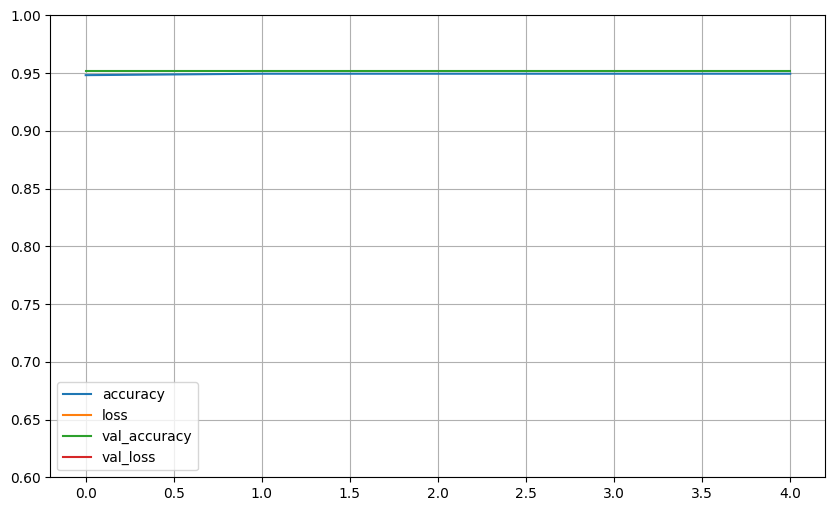

In [13]:
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0.60,1)
plt.show()

In [14]:
model.save("keras_base_spinal_canal_stenosis_l1_l2.h5")

In [ ]:
cropped_image = tf.image.resize_with_crop_or_pad(image, 100, 100)

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(5,5))
axes.imshow(np.squeeze(cropped_image.numpy()), cmap='gray')
axes.set_title('image')

In [4]:
model = keras.models.\
load_model("/kaggle/input/keras_base_scs_l1_l2/tensorflow2/default/1/keras_base_spinal_canal_stenosis_l1_l2.h5")

### Remove the squeeze from image file preprocessing

In [17]:
def read_and_parse_dicom_files_for_inf(full_file_path):
    tf.config.run_functions_eagerly(True)
    raw_image = tf.io.read_file(full_file_path)
    sp = tf.strings.split(tf.gather(tf.strings.split(full_file_path, 'images/'), 1), '/')
    N = tf.size(sp)
    LEN = tf.strings.length(tf.gather(sp, 0))+tf.strings.length(tf.gather(sp, 2))
    
    # Add missing file metadata to avoid warnnigs flooding
    if   LEN==12: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x92\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==13: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x92\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==14: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x94\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==15: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x94\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==16: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x96\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==17: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x96\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==18: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x98\x00\x00\x00\x02\x00\x01\x00')
    
    #image_bytes = tf.io.read_file(full_file_path)
    #image = tfio.image.decode_dicom_image(image_bytes, scale='auto', dtype=tf.float32)
    image = tfio.image.decode_dicom_image(raw_image, scale='auto', dtype=tf.float32)
    m, M=tf.math.reduce_min(image), tf.math.reduce_max(image)
    image = (tf.image.grayscale_to_rgb(image)-m)/(M-m)
    image = tf.image.resize(image, (128,128))
    return image

In [18]:
test_image = \
read_and_parse_dicom_files_for_inf('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/3481971518/1.dcm')

In [19]:
test_image.shape

TensorShape([1, 128, 128, 3])

In [20]:
y_proba = model.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


In [32]:
y_proba[0]

array([0.06547224, 0.87822175, 0.05630611], dtype=float32)

In [34]:
np.array([0.333333, 0.333333, 0.333333])

array([0.333333, 0.333333, 0.333333])

In [31]:
model.evaluate(test_ds)

220/220 ━━━━━━━━━━━━━━━━━━━━ 469s 2s/step - accuracy: 0.9496 - loss: 0.2659


[0.26565733551979065, 0.9497159123420715]

In [38]:
severity_levels = ['normal_mild', 'moderate', 'severe']
rows = {'44036939_spinal_canal_stenosis_l1_l2': y_proba[0]}

In [40]:
for key, value in rows.items():
    value_reshaped = value.reshape(1, -1)
    predictions = np.ascontiguousarray(value_reshaped)
    df = pd.DataFrame(predictions, columns=severity_levels)
    df.insert(loc=0, column='row_id', value=key)

In [41]:
df

,row_id,normal_mild,moderate,severe
0,44036939_spinal_canal_stenosis_l1_l2,0.065472,0.878222,0.056306
